# Kaggle Tabular playground series Dec21

### EDA

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, SelectFdr, SelectFpr, SelectFwe, chi2, f_classif
from functools import reduce
from sklearn.pipeline import Pipeline
import warnings

from PipelinesClasses_AG import reduce_mem_usage, preprocessDataset, FixFeatures, FeaturesEng, UseSelectedFeatures, pipeline_NestedCV
from Nested_CrossVal import final_tuning

sns.set()
warnings.filterwarnings('ignore')

In [20]:
df = pd.read_csv("dataML/trainDEC21.csv").drop("Id", axis=1)
test = pd.read_csv("dataML/test.csv")
print(df.shape)
print(df.dtypes.unique())
print(df.isnull().sum().any())
print(df.columns)

(4000000, 55)
[dtype('int64')]
False
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38

In [21]:
# reduce memory usage
df = reduce_mem_usage(df)

Mem. usage decreased to 244.14 Mb (85.5% reduction)


In [22]:
# check if dummies are ok
for c in df.columns:
    if len(df[c].unique()) == 1:
        print(c)

# Soil_Type7, Soil_Type15 = 0 in every case --> drop

Soil_Type7
Soil_Type15


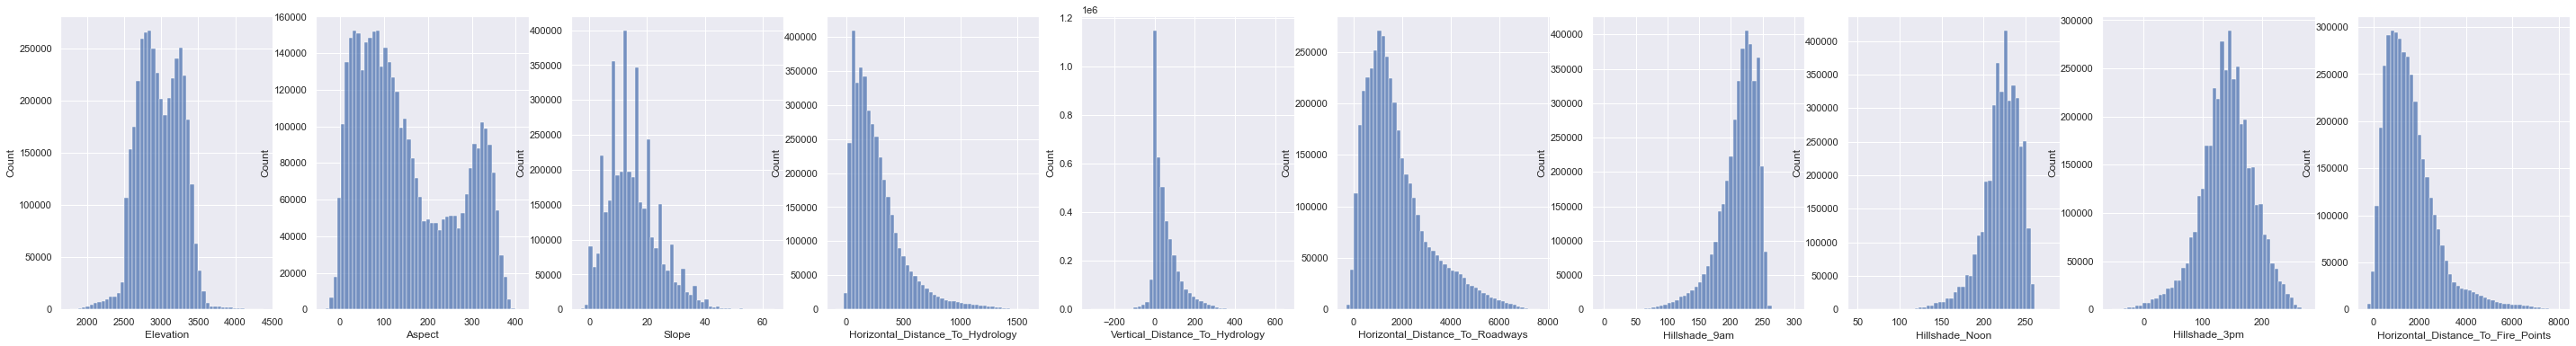

In [23]:
# Plot histograms
target_cols = [c for c in df.columns if len(df[c].unique()) > 8]  # select all continuous columns (no categorical) --> cover type (target) has 7 different values hence use > 8
fig, axs = plt.subplots(1, len(target_cols), figsize=(50, 6))
for i, col in enumerate(target_cols):
    sns.histplot(df[col], bins=50, ax=axs[i])

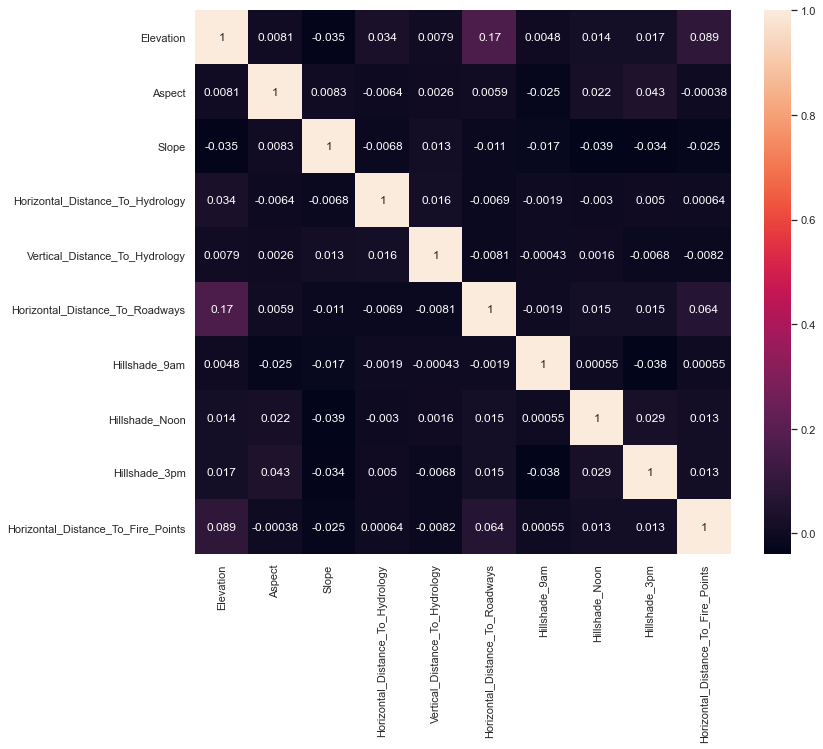

In [24]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correl_mat = df[target_cols].corr()
sns.heatmap(correl_mat, annot = True);

2    2262087
1    1468136
3     195712
7      62261
6      11426
4        377
5          1
Name: Cover_Type, dtype: int64

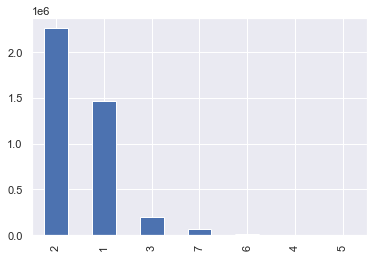

In [25]:
# Show target class
target = df["Cover_Type"]
(target.value_counts()).plot(kind="bar");
target.value_counts()

# drop the rows with class 5, 4, 6, 7

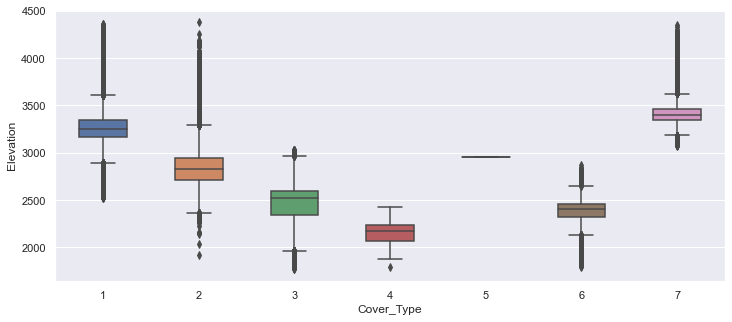

In [26]:
# BoxPlot for elevation given target class
plt.figure(figsize=(12, 5))
sns.boxplot(x="Cover_Type", y="Elevation", data=df, width=0.5);

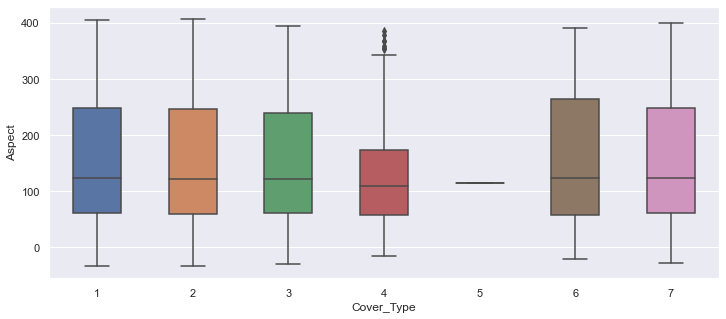

In [27]:
# BoxPlot for Aspect given target class
plt.figure(figsize=(12, 5))
sns.boxplot(x="Cover_Type", y="Aspect", data=df, width=0.5);

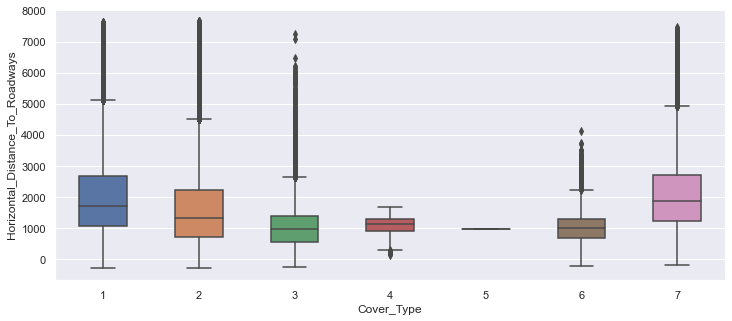

In [28]:
# BoxPlot for Aspect given target class
plt.figure(figsize=(12, 5))
sns.boxplot(x="Cover_Type", y="Horizontal_Distance_To_Roadways", data=df, width=0.5);

### Features Selection

It's possible to include the Features selection process in the Pipelines, but I've decided to keep it separate to show all the steps and visualize the results.

In [29]:
# Prepare the dataset for features selection 
df1 = preprocessDataset(df, pct=0.05, seed=222)   # use a random sample from entire df, drop classes 4,5,6
df1 = FixFeatures().transform(df1)                # fix Aspect and Hillshade features
df1 = FeaturesEng().transform(df1)                # create new features

df1.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Soil_type_count,Wilderness_area_count,mnhttn_dist_hydrlgy,Hillshade_mean,amp_Hillshade
3252449,2733,85,7,211,2,1627,184,209,66,692,...,0,0,0,0,2,0,1,213,153.000000,143
2819597,2462,190,18,767,27,1284,215,235,185,819,...,0,0,0,0,3,2,1,794,211.666667,50
1137358,3295,325,34,254,197,2234,242,221,225,572,...,0,0,0,0,1,0,1,451,229.333333,21
3980252,2873,94,7,118,36,5941,251,215,166,701,...,0,0,0,0,2,0,1,154,210.666667,85
19192,2886,138,9,60,3,2598,177,229,171,2302,...,0,0,0,0,2,1,1,63,192.333333,58


In [30]:
X_tr1 = df1.drop(["Cover_Type", "Soil_Type7", "Soil_Type15"], axis=1)
y_tr1 = df1["Cover_Type"]
scaler = MinMaxScaler()
X_tr1_sc = pd.DataFrame(scaler.fit_transform(X_tr1), columns=X_tr1.columns)

# Univariate features selection methods
univariate_fs_methods = [SelectKBest(chi2, k=20), SelectKBest(f_classif, k=20), 
                        SelectFdr(chi2, alpha=0.05), SelectFpr(chi2, alpha=0.05), SelectFwe(chi2, alpha=0.05)]
names = ["KBest_chi2", "KBest_fclass", "FDR", "FPR", "FWE"]

results = []
for name, method in zip(names, univariate_fs_methods):
    selection_method = method.fit(X_tr1_sc, y_tr1)
    selected = list(X_tr1_sc.columns[selection_method.get_support()])  # select column names given True/False indexes list obtained from .get_support()
    results.append(selected)
    print(f"{len(selected)} Features selected by {name}")

selected_by_all = reduce(np.intersect1d, [res for res in results if len(res)>0]) # list(set.intersection(*[set(x) for x in results])) # apply intersect1d to (a list of) multiple lists
reduce(np.intersect1d, results)
print("-"*100)
print(f"{len(selected_by_all)} Features selected by all the univariate methods: {selected_by_all}")

20 Features selected by KBest_chi2
20 Features selected by KBest_fclass
49 Features selected by FDR
49 Features selected by FPR
46 Features selected by FWE
----------------------------------------------------------------------------------------------------
18 Features selected by all the univariate methods: ['Elevation' 'Horizontal_Distance_To_Fire_Points'
 'Horizontal_Distance_To_Roadways' 'Soil_Type10' 'Soil_Type2'
 'Soil_Type23' 'Soil_Type3' 'Soil_Type32' 'Soil_Type33' 'Soil_Type38'
 'Soil_Type39' 'Soil_Type40' 'Soil_Type6' 'Soil_type_count'
 'Wilderness_Area1' 'Wilderness_Area2' 'Wilderness_Area3'
 'Wilderness_Area4']


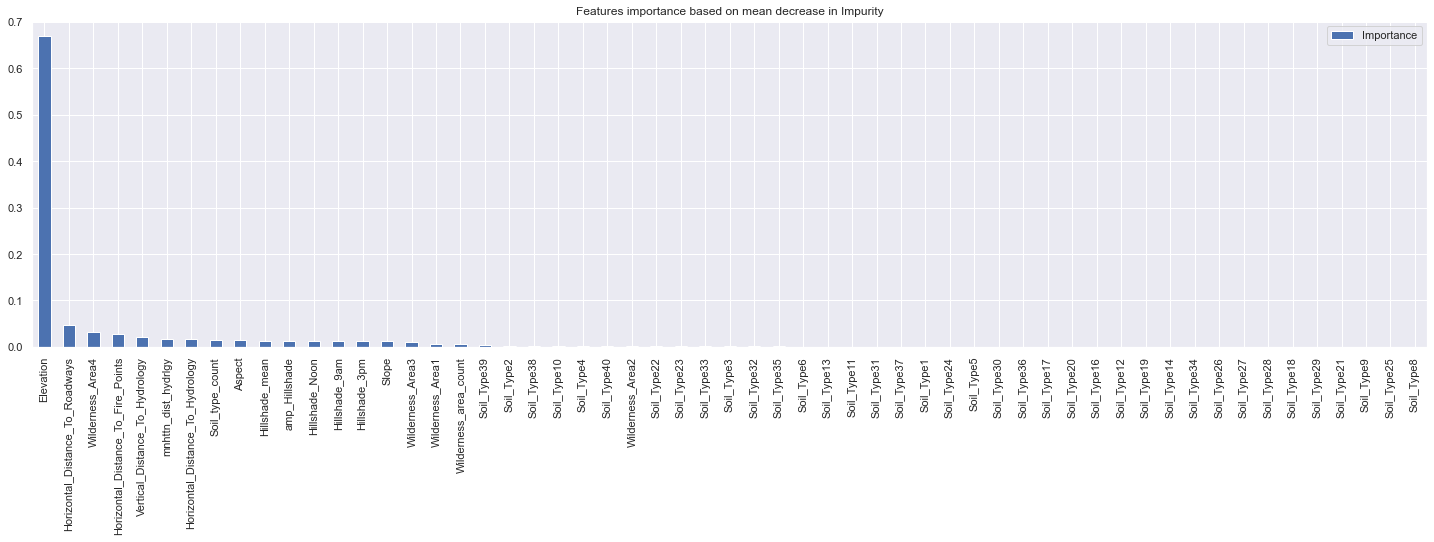

In [31]:
# Tree-based method
rf = RandomForestClassifier().fit(X_tr1, y_tr1)

# Mean decrease in Impurity
feat_imp_df = pd.DataFrame(rf.feature_importances_, index=X_tr1.columns, columns=["Importance"])
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
feat_imp_df.plot(kind='bar', figsize=(25,6))
plt.title("Features importance based on mean decrease in Impurity");

In [32]:
selectedRF = feat_imp_df[feat_imp_df["Importance"] > 0.01]
selectedRF = list(selectedRF.index)
print(f"{len(selectedRF)} features with importance score > 0.01 selected by Tree-based method: {selectedRF}")
print("------------------------------------------------------------------------------------------")

all_features_selected = list(selected_by_all) + selectedRF
feat_to_keep = list(set(all_features_selected))
print(f"{len(feat_to_keep)} Features selected: {feat_to_keep}")

16 features with importance score > 0.01 selected by Tree-based method: ['Elevation', 'Horizontal_Distance_To_Roadways', 'Wilderness_Area4', 'Horizontal_Distance_To_Fire_Points', 'Vertical_Distance_To_Hydrology', 'mnhttn_dist_hydrlgy', 'Horizontal_Distance_To_Hydrology', 'Soil_type_count', 'Aspect', 'Hillshade_mean', 'amp_Hillshade', 'Hillshade_Noon', 'Hillshade_9am', 'Hillshade_3pm', 'Slope', 'Wilderness_Area3']
------------------------------------------------------------------------------------------
28 Features selected: ['Soil_Type40', 'mnhttn_dist_hydrlgy', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_3pm', 'Soil_Type3', 'Wilderness_Area4', 'amp_Hillshade', 'Vertical_Distance_To_Hydrology', 'Wilderness_Area2', 'Soil_Type38', 'Slope', 'Wilderness_Area1', 'Soil_Type39', 'Aspect', 'Hillshade_mean', 'Soil_Type33', 'Hillshade_Noon', 'Wilderness_Area3', 'Soil_Type23', 'Elevation', 'Soil_Type6', 'Horizontal_Distance_To_Hydrology', 'Soil_Type10', 'Horizontal_Distance_To_

### Model Selection: NESTED CV
(very small sub-sample as an example)

- KNeighborsClassifier
- RandomForestClassifier
- LinearDiscriminantAnalysis
- SVC
- XGBoost

In [33]:
# Define X and y train with new sub-sample
df2 = preprocessDataset(df, pct=0.005, seed=6584) 
X_train = df2.drop(["Cover_Type", "Soil_Type7", "Soil_Type15"], axis=1)
y_train = df2["Cover_Type"]
print(f"Number of rows in the training set: {len(X_train)}")
print("-----------------------------------------------")
print("Nested CV results:")
nestedCV_results = pipeline_NestedCV(X_train, y_train, feat_to_keep)    # use Pipelines_AG.py
nestedCV_results

Number of rows in the training set: 19947
-----------------------------------------------
Nested CV results:
                              LDA  RandomForest        SVC    XGBoost  \
OuterCV_average_Score%  89.908257     93.537875  88.454404  94.866396   
OuterCV_std%             0.180896      0.274680   0.565058   0.167627   

                              kNN  
OuterCV_average_Score%  79.831554  
OuterCV_std%             0.107054  


,LDA,RandomForest,SVC,XGBoost,kNN
OuterCV_average_Score%,89.908257,93.537875,88.454404,94.866396,79.831554
OuterCV_std%,0.180896,0.274680,0.565058,0.167627,0.107054


In [35]:
# Identify best model and tune
best_mod = Pipeline([("fix", FixFeatures()), ("eng", FeaturesEng()), ("select", UseSelectedFeatures(feat_to_keep)), ("xgb", XGBClassifier())])
best_grid = {"xgb__gamma" : [0, 1], "xgb__n_estimators": [500, 1500], "xgb__subsample": [0.5, 0.85]}
best_mod_tuned = final_tuning(best_mod, best_grid, 4, X_train, y_train, seed=11)  # stratifiedKfold and GridSearchCV
print(f"Best model with tuned hyperparameters: {best_mod_tuned['xgb']}")

Best model with tuned hyperparameters: Pipeline(steps=[('fix', FixFeatures()), ('eng', FeaturesEng()),
                ('select',
                 UseSelectedFeatures(selected_feat=['Soil_Type40',
                                                    'mnhttn_dist_hydrlgy',
                                                    'Horizontal_Distance_To_Roadways',
                                                    'Hillshade_9am',
                                                    'Hillshade_3pm',
                                                    'Soil_Type3',
                                                    'Wilderness_Area4',
                                                    'amp_Hillshade',
                                                    'Vertical_Distance_To_Hydrology',
                                                    'Wilderness_Area2',
                                                    'Soil_Type38', 'Slope',
                                                    'Wildernes

### Final Predictions

In [38]:
# Define X and y train using bigger sub-sample with 15% of the dataset
df3 = preprocessDataset(df, pct=0.15, seed=6799) 
X_train = df3.drop(["Cover_Type", "Soil_Type7", "Soil_Type15"], axis=1)
y_train = df3["Cover_Type"]

# Tuned model --> extract only the model from the previous Pipeline (or just use the same pipeline)
mod_xgb = best_mod_tuned['xgb'] # XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1, importance_type='gain', interaction_constraints='', learning_rate=0.300000012, max_delta_step=0, max_depth=6, min_child_weight=1, monotone_constraints='()', n_estimators=1500, n_jobs=0, num_parallel_tree=1, objective='multi:softprob', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.85, tree_method='exact', validate_parameters=1, verbosity=None)
xgb = Pipeline([("fix", FixFeatures()), ("eng", FeaturesEng()), ("select", UseSelectedFeatures(feat_to_keep)), ("xgb", mod_xgb)])
xgb.fit(X_train, y_train)

# Submission file
predictions = xgb.predict(test)
df_sub = pd.DataFrame(predictions, index=test["Id"], columns=["Cover_Type"])
df_sub.to_csv("Submission_AG.csv")

In [39]:
df_sub.head()

,Cover_Type
Id,
4000000,2
4000001,2
4000002,2
4000003,2
4000004,2
